# Homework 06 — IANNwTF
## Group 27
Deadline: Dec 5, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Dataset
The Cifar10 dataset contains 60.000 coloured images. Each image corresponds to one of 10 categories.

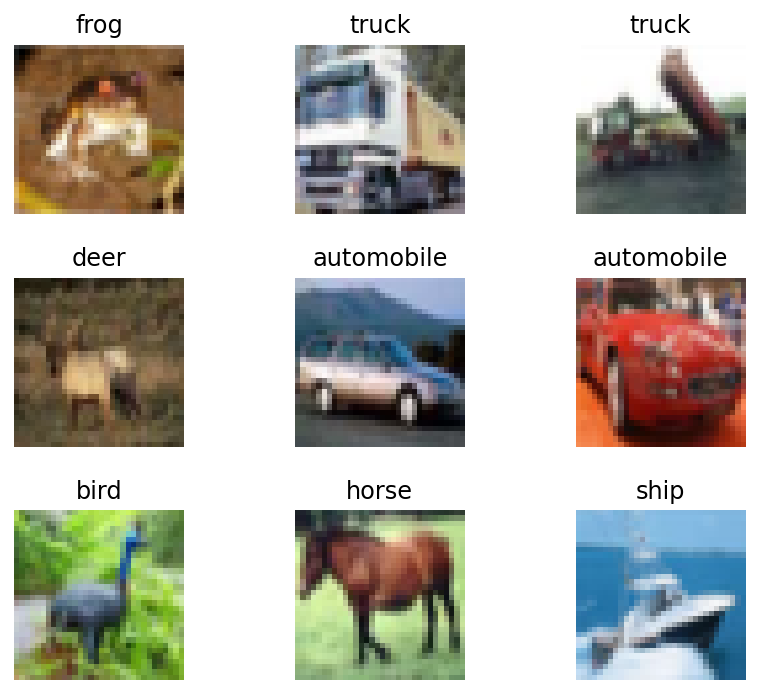

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

text_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(3,3, figsize=(6,5))
fig.tight_layout()
ax = ax.flatten()
for i in range(9):
    image = training_inputs[i]
    label = text_labels[training_labels[i][-1]]
    ax[i].imshow(image)
    ax[i].set_title(label)
    ax[i].axis("off")

In [3]:
def prepare_data(ds):
    # normalise images and then one-hot-encode the targets
    ds = ds.map(lambda inputs, targets: ((2*(inputs/255)-1), tf.one_hot(tf.squeeze(targets), 10)))
    # batch, shuffle and prefetch
    ds = ds.batch(batch_size).shuffle(batch_size).prefetch(128)
    return ds

In [4]:
batch_size = 64

# split into training and test datasets
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# prepare the datasets
train_ds = prepare_data(training_dataset)
test_ds = prepare_data(test_dataset)

## DenseNet
The DenseNet network is divided into multiple densely connected dense blocks, with transition layers between the dense blocks.

In [5]:
class ConvBlock(tf.keras.layers.Layer):
    
    """
    Convolutional block to use inside a DenseBlock of a DenseNet
    
    Args:
    x (KerasTensor) : Input to the block
    
    n_filters (int) : number of filters used within the block
    """
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()

        # batch normalisation and activation function (ReLU)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
        self.activation_1 = tf.keras.activations.relu
        
        # convolutional layers
        self.conv_1 = tf.keras.layers.Conv2D(filters = n_filters,
                                             kernel_size = 1,
                                             activation = None,
                                             padding = 'same',                           
                                             kernel_regularizer = tf.keras.regularizers.L2(0.01))
        
        self.conv_2 = tf.keras.layers.Conv2D(filters = n_filters,
                                             kernel_size = 3,
                                             activation = None,
                                             padding = 'same',                           
                                             kernel_regularizer = tf.keras.regularizers.L2(0.01))
        
        # batch normalisation, activation function (ReLU), dropout
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         
        self.activation_2 = tf.keras.activations.relu
        self.dropout = tf.keras.layers.Dropout(rate = 0.1)
        # concatenate 
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs, training = True):
        x = self.batch_norm_1(inputs, training)
        x = self.activation_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x) 
        x = self.batch_norm_2(x, training)
        x = self.activation_2(x)
        x = self.dropout(x, training)
        output = self.concat([x, inputs]) 
        return output

In [6]:
class DenseBlock(tf.keras.layers.Layer):
    
    def __init__(self, list_n_filters):
      super(DenseBlock, self).__init__()

      self.conv_blocks = []
      for n_filters in list_n_filters:
          self.conv_blocks.append(ConvBlock(n_filters))
    
    def call(self, x, training = True):
      for conv_block in self.conv_blocks:
        x = conv_block(x, training)
      return x

In [7]:
# Transition layers of a DenseNet change feature-map sizes via convolution and pooling
class TransitionLayer(tf.keras.layers.Layer):
    
    def __init__(self, n_channels):
        super(TransitionLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters = n_channels,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'valid',        
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
        self.batch_norm = tf.keras.layers.BatchNormalization()                                         
        self.activation = tf.keras.activations.relu
        self.pool = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'valid')
        
    def call(self, x, training = True):
        x = self.conv(x)
        x = self.batch_norm(x, training)
        x = self.activation(x)
        x = self.pool(x)
        return x

In [8]:
class DenseNet(tf.keras.Model): 
  
  def __init__(self, n_dense_blocks, list_n_filters, growth_rate):
        super(DenseNet, self).__init__()

        self.conv = tf.keras.layers.Conv2D(filters = 32,
                                             kernel_size = 3,
                                             activation = None,
                                             padding = 'valid',                               
                                             kernel_regularizer = tf.keras.regularizers.L2(0.01),        
                                             input_shape = (32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
        self.activation = tf.keras.activations.relu
        self.dropout_1 = tf.keras.layers.Dropout(rate = 0.6)    

        n_conv_blocks = len(list_n_filters)
        n_channels = growth_rate * n_conv_blocks
        self.all_layers = []
        for i in range(n_dense_blocks - 1):
            self.all_layers.append(DenseBlock(list_n_filters))
            self.all_layers.append(TransitionLayer(n_channels)) 
        self.last_dense_block = DenseBlock(list_n_filters) # no transition layer after the last dense block

        # classification
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout_2 = tf.keras.layers.Dropout(rate = 0.5)                                                  
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        
  def call(self, x, training = True):
    x = self.conv(x)
    x = self.batch_norm_1(x, training)
    x = self.activation(x)
    x = self.dropout_1(x, training)
    
    for i in self.all_layers:
        x = i(x, training)
    x = self.last_dense_block(x, training)
    
    x = self.global_pool(x)
    x = self.dropout_2(x, training)
    x = self.output_layer(x)
    return x

## Training and 📈

In [9]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric):
    # training step
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs[accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric, accuracy_metric):
    # test step
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs["test_" + accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["test_loss"] = loss_metric.result()
    return logs

In [10]:
tf.keras.backend.clear_session()

# hyperparameters
epochs = 10
learning_rate = 0.001

# initialize the model
n_dense_blocks = 3
list_n_filters = [64, 32, 32, 16, 8]
n_conv_blocks = len(list_n_filters)
growth_rate = 30
model = DenseNet(n_dense_blocks, list_n_filters, growth_rate)  

# Initialize the loss function: categorical cross entropy
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)

# Metrics
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'test_loss': [], 'categorical_accuracy': [], 'test_categorical_accuracy': []}


def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

# training
for epoch in range(epochs):
    reset_metrics([accuracy_metric,loss_metric])
    for inputs, targets in train_ds:
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

# test
    reset_metrics([accuracy_metric,loss_metric])
    for (inputs_batch, targets_batch) in test_ds:
        logs = test_step(inputs_batch, targets_batch, loss_fn, loss_metric, accuracy_metric)
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...categorical_accuracy: 0.4605
...loss: 1.4758
...Evaluation results:
...test_categorical_accuracy: 0.5228
...test_loss: 1.3739
Results at the end of epoch 1
...categorical_accuracy: 0.6169
...loss: 1.0736
...Evaluation results:
...test_categorical_accuracy: 0.5174
...test_loss: 1.3587
Results at the end of epoch 2
...categorical_accuracy: 0.6810
...loss: 0.9000
...Evaluation results:
...test_categorical_accuracy: 0.6623
...test_loss: 0.9459
Results at the end of epoch 3
...categorical_accuracy: 0.7226
...loss: 0.7966
...Evaluation results:
...test_categorical_accuracy: 0.7155
...test_loss: 0.8322
Results at the end of epoch 4
...categorical_accuracy: 0.7531
...loss: 0.7164
...Evaluation results:
...test_categorical_accuracy: 0.7301
...test_loss: 0.7774
Results at the end of epoch 5
...categorical_accuracy: 0.7718
...loss: 0.6626
...Evaluation results:
...test_categorical_accuracy: 0.7424
...test_loss: 0.7520
Results at the end of epoch 6
...categorical_a

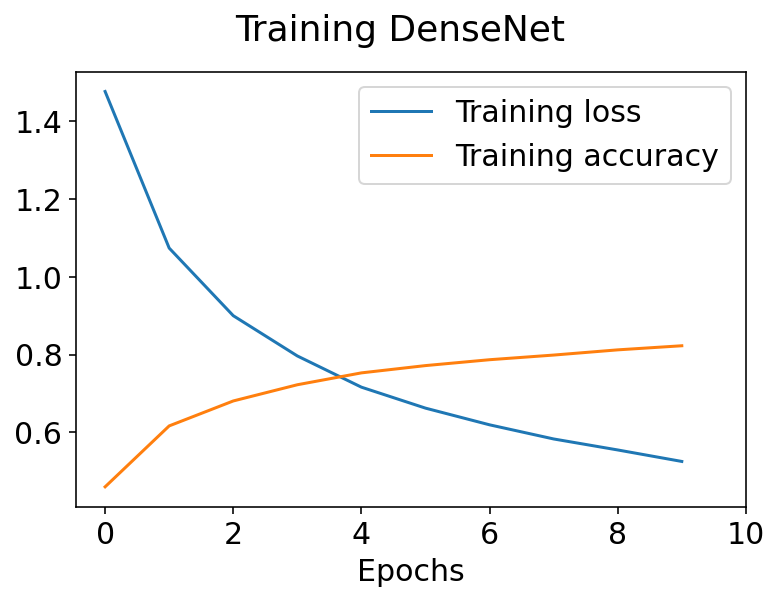

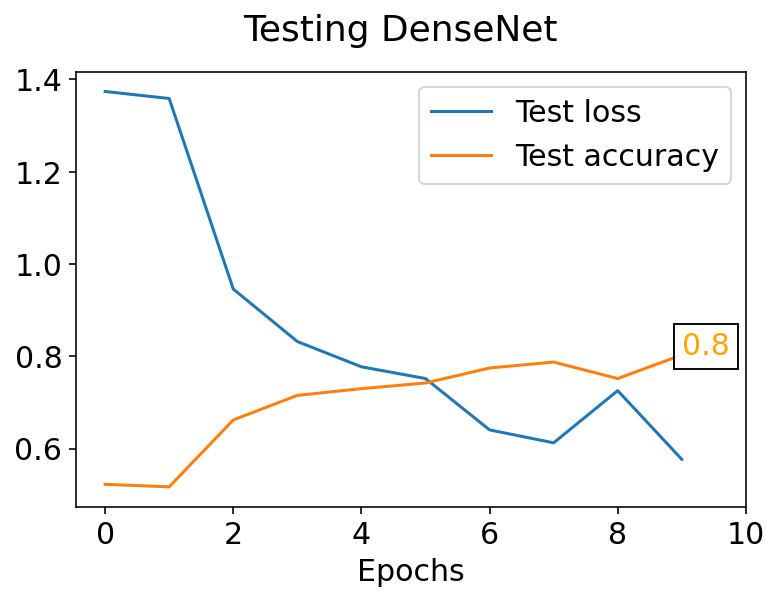

In [11]:
plt.rcParams['font.size'] = 15
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['categorical_accuracy'], label='Training accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(epochs + 1, step=1))
plt.legend()
plt.suptitle("Training metrics")


plt.figure()
plt.suptitle("Testing metrics")
plt.plot(hist['test_loss'], label='Test loss')
plt.plot(hist['test_categorical_accuracy'], label='Test accuracy')
plt.text(len(hist['test_categorical_accuracy'])-1,
         hist['test_categorical_accuracy'][-1],
         round(hist['test_categorical_accuracy'][-1].numpy(), 2),
         color = 'orange',
         bbox = dict(facecolor = 'white', alpha = 0.95))
plt.xticks(np.arange(epochs + 1, step=1))
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [12]:
model.summary()

Model: "dense_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_block (DenseBlock)    multiple                  74640     
                                                                 
 transition_layer (Transitio  multiple                 28350     
 nLayer)                                                         
                                                                 
 dense_block_1 (DenseBlock)  multiple                  94